# Experiment: Heatmap
The goal of this experiment is to test the model for which feautres of the dog photos are actually the most important. We use LR halving every 10th epoch starting at 0.015

# Import statements

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import pathlib

# Model training

In [91]:
def get_classes(n: int):
    dog_class_directory = 'c:\\GitRepository\\Dog-Breed-Classifier' + '/dog_classes'
    return os.listdir(dog_class_directory)[5:n+5]

                    
selected_classes = ['231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier', '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier','211-n000009-cairn', '203-n000021-Tibetan_terrier', '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont', ]                    
                    
print(len(selected_classes))
print(selected_classes)

8
['231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier', '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier', '211-n000009-cairn', '203-n000021-Tibetan_terrier', '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont']


In [34]:
# Print the number of elements (images) in each class
dog_class_directory = 'c:\\GitRepository\\Dog-Breed-Classifier' + '/dog_classes'  # Define the directory path again

for c in selected_classes:
    class_directory = os.path.join(dog_class_directory, c)  # Full path to the class folder
    # List files in the class folder and count them
    num_images = len([f for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))])
    print(f"Class '{c}' has {num_images} images.")


NameError: name 'selected_classes' is not defined

In [ ]:
dog_class_directory = 'c:\\GitRepository\\Dog-Breed-Classifier' + '/dog_classes'

# Set up the figure for displaying images
plt.figure(figsize=(2, 4))

# Loop over each class and display the first image
for i, class_name in enumerate(selected_classes):
    class_directory = os.path.join(dog_class_directory, class_name)
    image_files = os.listdir(class_directory)
    
    # Check if there are images in the class directory
    if image_files:
        first_image_path = os.path.join(class_directory, image_files[0])
        
        # Load and display the first image
        img = load_img(first_image_path, target_size=(224, 224))  # Resize for consistent display size
        ax = plt.subplot(3, 3, i + 1)  # Adjust grid as per number of classes
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


### Heatmap

In [ ]:
import tensorflow as tf

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [107]:
dog_class_directory = 'c:\\GitRepository\\Dog-Breed-Classifier' + '/dog_classes'
dog_img = dog_class_directory + '/231-n000081-silky_terrier' + '/n122719.jpg'
img_size = (224,224)

In [118]:
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import layers, Model

# Load the MobileNet model without the top layers
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3), classes = 8)

# Define the augmented input by applying data augmentation to the input layer
#inputs = tf.keras.Input(shape=(224, 224, 3))
""" preprocess = tf.keras.applications.mobilenet.preprocess_input(inputs) """
#x = conv_base(preprocess, training=False)  


# Add custom top layers
x = GlobalAveragePooling2D()(conv_base.output)  # Pooling layer
#x = Dense(1024, activation='relu')(x)  # Dense layer
x = Dense(1024, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01))(x)  # Dense layer with L2
#x = layers.Dropout(0.5)(x)  # Optional dropout
preds = Dense(len(selected_classes), activation='softmax')(x)  # Final output layer

# Create the final model
model = Model(inputs=conv_base.input, outputs=preds)
model.summary()
last_conv_layer_name = 'conv_pw_13_relu'

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,286,664 (16.35 MB)

 Trainable params: 4,264,776 (16.27 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [114]:
model.get_layer(last_conv_layer_name)

<ReLU name=conv_pw_13_relu, built=True>

c:\Users\theah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_3455']. Received: the structure of inputs=*
  warnings.warn(


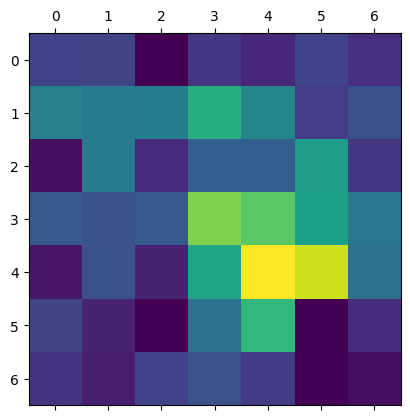

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
#model.layers[-1].activation = None

img_tensor = preprocess_input(get_img_array(dog_img, img_size))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

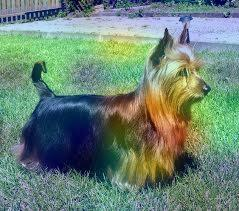

In [120]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(dog_img, heatmap)

In [132]:
import os
import random

def select_random_images_from_classes(root_path, selected_classes, num_samples=3):
    """
    Select random image paths from each class folder.

    Parameters:
    - root_path (str): The root directory containing class folders.
    - selected_classes (list): A list of class folder names.
    - num_samples (int): Number of random images to select from each class folder.

    Returns:
    - dict: A dictionary where keys are class names and values are lists of randomly selected image paths.
    """
    selected_images = {}
    
    for class_folder in selected_classes:
        class_path = os.path.join(root_path, class_folder)

        # Check if the class folder exists
        if not os.path.isdir(class_path):
            print(f"Class folder not found: {class_path}")
            continue

        # Get all files in the folder
        all_images = [os.path.join(class_path, img) for img in os.listdir(class_path)
                      if os.path.isfile(os.path.join(class_path, img))]
        
        # Select random samples (ensure enough images exist)
        if len(all_images) < num_samples:
            print(f"Not enough images in class '{class_folder}'. Found {len(all_images)}, needed {num_samples}.")
            selected_images[class_folder] = all_images
        else:
            selected_images[class_folder] = random.sample(all_images, num_samples)
    
    return selected_images

# Example usage
root_path = dog_class_directory  # Replace with the root path to your dataset
selected_classes = [
    '231-n000081-silky_terrier', '340-n000120-Yorkshire_terrier',
    '202-n000020-Australian_terrier', '203-n000016-Norwich_terrier',
    '211-n000009-cairn', '203-n000021-Tibetan_terrier',
    '215-n000038-Lhasa', '211-n000052-Dandie_Dinmont',
]

selected_class = ['231-n000081-silky_terrier']
random_images = select_random_images_from_classes(root_path, selected_class, num_samples=5)

#random_images = select_random_images_from_classes(root_path, selected_classes, num_samples=3)



Class '231-n000081-silky_terrier'


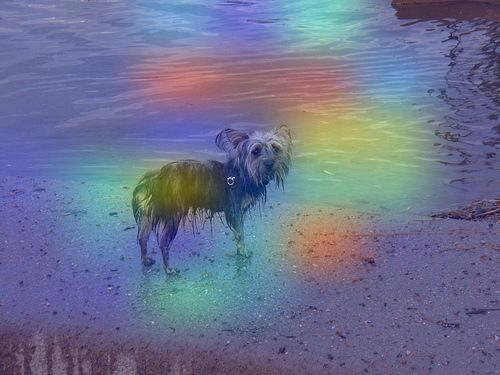

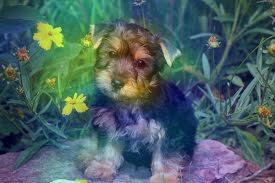

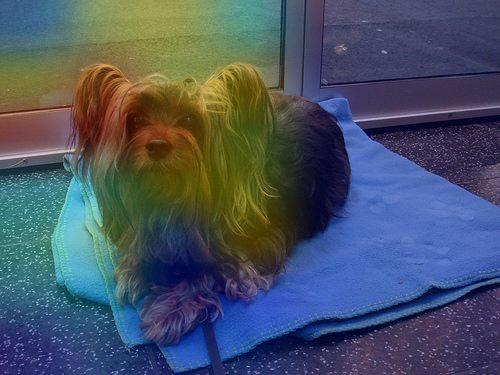

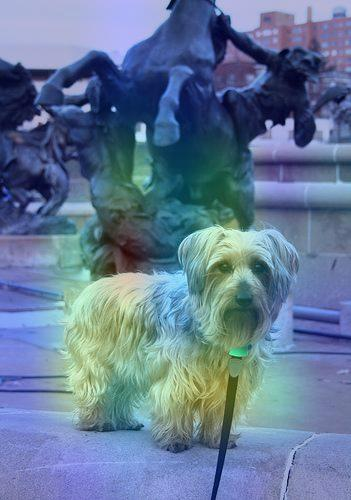

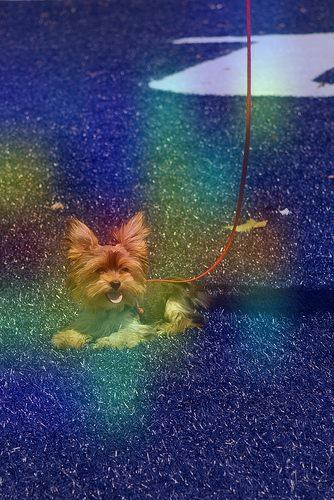

In [144]:
for class_name, image_paths in random_images.items():
    print(f"Class '{class_name}'")
    for dog_image in image_paths:
        img_tensor = preprocess_input(get_img_array(dog_image, img_size))
        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
        save_and_display_gradcam(dog_image, heatmap)

In [7]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:3]:
    print("off: ", layer)
    layer.trainable=False
for layer in model.layers[3:]:
    print("on: ", layer)
    layer.trainable=True
    

Total number of layers is 6
Number of pretrained base layers is 86
off:  <InputLayer name=input_layer_2, built=True>
off:  <Sequential name=sequential, built=True>
off:  <Functional name=mobilenet_1.00_224, built=True>
on:  <GlobalAveragePooling2D name=global_average_pooling2d, built=True>
on:  <Dense name=dense, built=True>
on:  <Dense name=dense_1, built=True>


In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=32,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

Found 1816 files belonging to 8 classes.
Using 1453 files for training.
Found 1816 files belonging to 8 classes.
Using 363 files for validation.


In [9]:
from tensorflow.keras.optimizers import schedules

boundaries = [460, 920, 1380, 1840]
values = [0.015, 0.0075, 0.00375, 0.001875, 0.0009375]
constant_decay_scheduler = schedules.PiecewiseConstantDecay(boundaries, values)

In [27]:
sgd_optimizer = optimizers.SGD(learning_rate=constant_decay_scheduler, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=50)

Epoch 1/50


c:\Users\theah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - accuracy: 0.5173 - loss: 11.2443 - val_accuracy: 0.7769 - val_loss: 8.8289
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.8868 - loss: 8.0286 - val_accuracy: 0.7906 - val_loss: 6.8421
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 402ms/step - accuracy: 0.9325 - loss: 6.0521 - val_accuracy: 0.7934 - val_loss: 5.3373
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 471ms/step - accuracy: 0.9396 - loss: 4.6000 - val_accuracy: 0.8320 - val_loss: 4.2461
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - accuracy: 0.9527 - loss: 3.5262 - val_accuracy: 0.8099 - val_loss: 3.4052
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.9755 - loss: 2.6798 - val_accuracy: 0.8099 - val_loss: 2.8352
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.9810 - loss: 2.0632 - val_accuracy: 0.7934 - val_loss: 2.2284
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 379ms/step - accuracy: 0.9823 - loss: 1.5978 - val_accuracy: 0.80

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


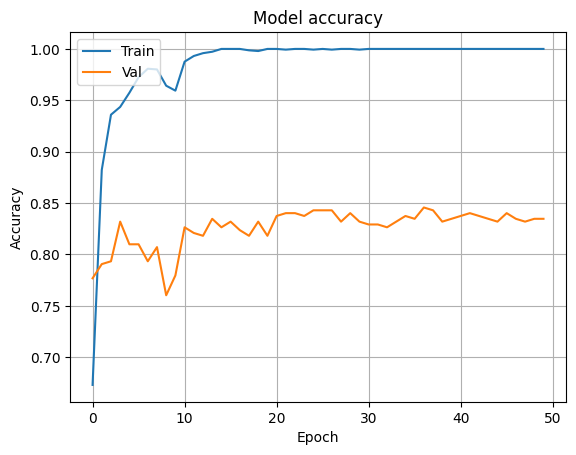

In [28]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### We are now ready to start training the model using


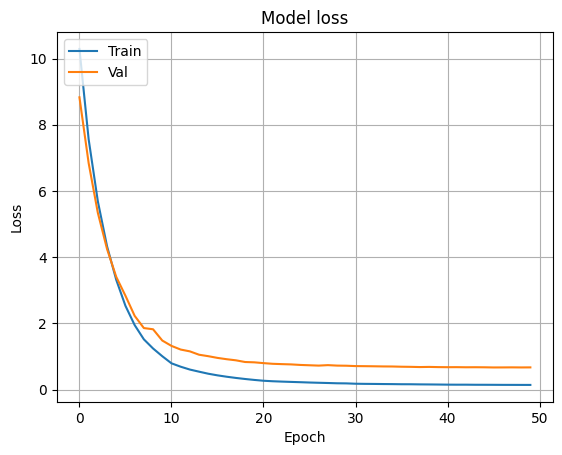

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [12]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(val_dataset, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.8350 - loss: 0.8555
test loss, test acc: [0.8950561881065369, 0.8374655842781067]


In [14]:
x_test_list = []
y_test_list = []

# Iterate over each (x, y) in the dataset, taking only y (labels)
for img, labels in val_dataset:
    x_test_list.append(img.numpy())
    y_test_list.append(labels.numpy())  # Convert labels to NumPy array and add to list
    
x_test_array = np.vstack(x_test_list) 
y_test_array = np.vstack(y_test_list) 

In [15]:
# Generate predictions directly on the dataset
predictions = model.predict(x_test_array, verbose=False)
print('predictions shape:', predictions.shape)
print(predictions)

predictions shape: (363, 8)
[[4.2871261e-04 9.9095297e-01 8.1101200e-03 ... 1.9544184e-06
  6.0199409e-06 3.9849683e-06]
 [9.9719977e-01 2.4328104e-04 2.5516727e-03 ... 3.3556039e-06
  6.3875581e-07 1.1025073e-06]
 [1.3452469e-02 9.9796997e-03 6.4894043e-02 ... 1.1993542e-02
  2.1155796e-03 3.7077717e-03]
 ...
 [7.3352392e-05 6.1082828e-05 3.4433324e-03 ... 9.0360402e-08
  7.2058947e-07 5.1839361e-06]
 [3.2538208e-03 7.5066549e-04 2.0394773e-04 ... 3.5532266e-03
  5.3932239e-05 1.3994798e-03]
 [6.5943658e-01 2.7336690e-01 4.1007824e-02 ... 3.9686362e-04
  2.3663582e-05 6.7481706e-05]]


In [16]:
y_test_class = np.argmax(y_test_array, axis=1)
predictions_class = np.argmax(predictions,axis=1)
print('predictions.shape:',predictions.shape)
print('predictions_class.shape:',predictions_class.shape)

predictions.shape: (363, 8)
predictions_class.shape: (363,)


In [17]:
print('predictions_class[:20]',predictions_class[:20])
print('y_test_class[:20]     ',y_test_class[:20])

predictions_class[:20] [1 0 4 4 6 2 6 6 4 4 6 7 0 2 1 0 6 1 4 0]
y_test_class[:20]      [1 0 4 4 5 1 6 6 4 4 6 7 0 2 1 2 6 1 4 0]


In [18]:
import numpy as np

# Use the get_accuracy function
def get_accuracy(predictions_class, y_test):
    # Convert one-hot encoded y_test to class indices
    y_test_class = np.argmax(y_test, axis=1)
    # Calculate number of correct predictions
    num_correct = np.sum(predictions_class == y_test_class)
    # Calculate accuracy
    accuracy = num_correct / len(y_test_class)
    return accuracy

# Assuming predictions_class contains predicted class indices
accuracy = get_accuracy(predictions_class, y_test_array)
print('accuracy:', accuracy)

accuracy: 0.837465564738292


Confusion matrix, without normalization
Normalized confusion matrix


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

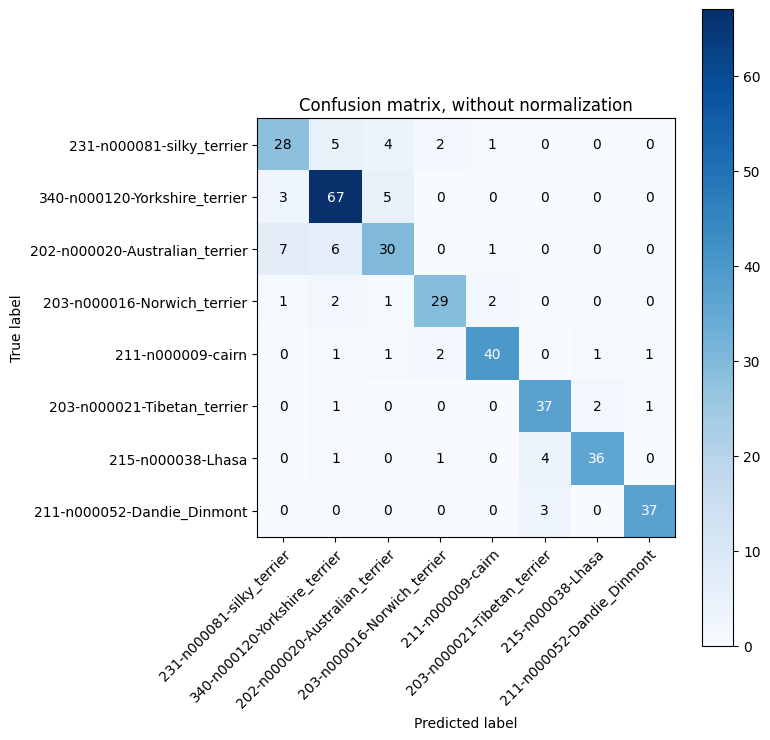

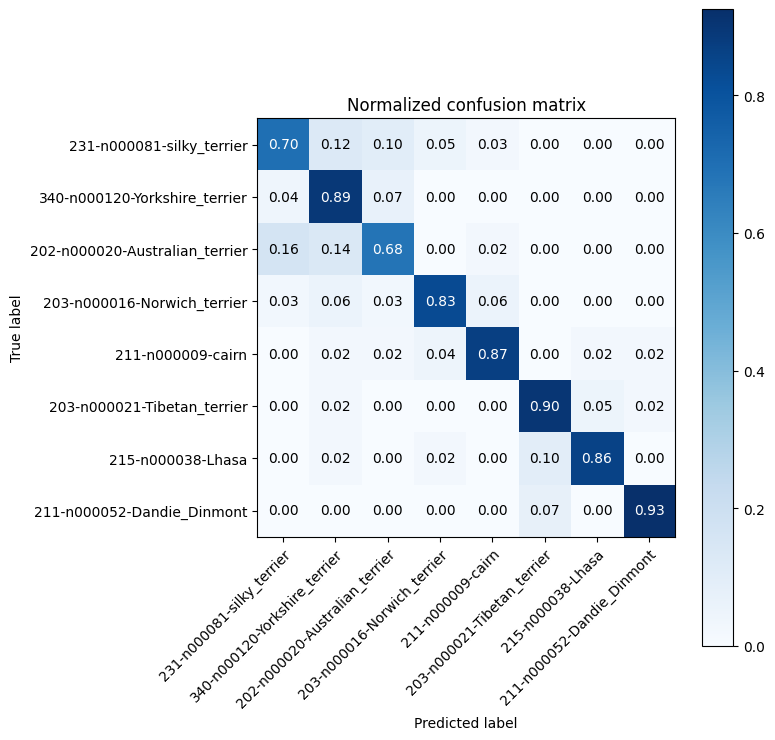

In [ ]:
# From:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8,8))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
labels = selected_classes
N = predictions_class.shape[0]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_class[:N], predictions_class, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [21]:
import numpy as np

def get_top_k_accuracy_per_class(predictions, y_test, k):
    """
    Calculate the top-k accuracy for each class in the dataset and return as an array.

    Args:
        predictions (np.ndarray): Array of prediction probabilities, shape (num_samples, num_classes).
        y_test (np.ndarray): Array of true class indices, shape (num_samples,).
        k (int): Number of top predictions to consider.

    Returns:
        np.ndarray: An array where each row contains [class, top-k accuracy].
    """
    # Convert predictions to top-k predicted class indices
    top_k_predictions = np.argsort(predictions, axis=1)[:, -k:]

    # Get the unique classes in y_test
    unique_classes = np.unique(y_test)

    # Initialize a list to collect results
    results = []

    # Iterate through each class and calculate top-k accuracy
    for cls in unique_classes:
        # Get indices of samples belonging to the current class
        cls_indices = np.where(y_test == cls)[0]
        
        # Filter top-k predictions and true labels for the current class
        cls_top_k_predictions = top_k_predictions[cls_indices]
        cls_true_labels = y_test[cls_indices]

        # Calculate top-k accuracy for the current class
        matches = [cls_true_labels[i] in cls_top_k_predictions[i] for i in range(len(cls_true_labels))]
        cls_accuracy = np.sum(matches) / len(cls_true_labels) if len(cls_true_labels) > 0 else 0

        # Append the class and its accuracy as a row
        results.append(cls_accuracy)

    # Convert the results to a numpy array
    return np.array(results)


In [22]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import top_k_accuracy_score
import pandas as pd

labels = selected_classes
recalls = recall_score(y_test_class, predictions_class, average=None)
precisions = precision_score(y_test_class, predictions_class, average=None)
top_3 = get_top_k_accuracy_per_class(predictions, y_test_class, 3)

# Create a DataFrame
data = {
    "Class Label": labels,
    "Precision": precisions,
    "Recall": recalls,
    "Top-3 accuracy": top_3
}
table = pd.DataFrame(data)

styled_table = table.style.set_table_styles(
    [
        {"selector": "thead", "props": [("background-color", "#4CAF50"), ("color", "white")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f2f2f2")]},
        {"selector": "tbody tr:hover", "props": [("background-color", "#ddd")]},
    ]
).set_properties(**{'text-align': 'center'})

print("Top 3 accuracy among all classes: ", top_k_accuracy_score(y_test_class, predictions, k=3))
styled_table  # Will display nicely in a Jupyter Notebook

Top 3 accuracy among all classes:  0.9752066115702479


,Class Label,Precision,Recall,Top-3 accuracy
0,231-n000081-silky_terrier,0.717949,0.700000,0.950000
1,340-n000120-Yorkshire_terrier,0.807229,0.893333,1.000000
2,202-n000020-Australian_terrier,0.731707,0.681818,0.977273
3,203-n000016-Norwich_terrier,0.852941,0.828571,0.942857
4,211-n000009-cairn,0.909091,0.869565,0.956522
5,203-n000021-Tibetan_terrier,0.840909,0.902439,0.975610
6,215-n000038-Lhasa,0.923077,0.857143,0.976190
7,211-n000052-Dandie_Dinmont,0.948718,0.925000,1.000000
